# Fake News Detection

**Author**: Marcelo Scatena
***
March 2022

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [4]:
from nltk.corpus import stopwords
import re
from nltk.stem.wordnet import WordNetLemmatizer
import string

In [5]:
from wordcloud import WordCloud

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [7]:
def print_cm_with_labels(y_true, 
                         y_pred):
    '''
    Takes the true values and predicted values of a classifier and 
    plots a confusion matrix (normalized by predictions) using 
    a list of given display labels.
    '''
    disp_labels = ['True', 'Fake']
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=disp_labels)

    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax)
    ax.grid(False)
    disp.ax_.set_xticklabels(disp_labels)
    return None

In [8]:
from sklearn.metrics import accuracy_score
import numpy as np

## Vectorization

In [2]:
%store -r df_train_clean
%store -r df_val_clean
%store -r df_test_clean

In [3]:
X_train_clean = df_train_clean['statement']
y_train_clean = df_train_clean['label']
X_val_clean = df_val_clean['statement']
y_val_clean = df_val_clean['label']
X_test_clean = df_test_clean['statement']
y_test_clean = df_test_clean['label']

In [4]:
# Import Word2Vec from Python library gensim and apply to processed train data
from gensim.models import Word2Vec
from nltk import word_tokenize

X_train_w2v = X_train_clean.map(word_tokenize)

w2v_model = Word2Vec(X_train_w2v, window=5, min_count=1, workers=4)
w2v_model.train(X_train_w2v, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)

wv = w2v_model.wv

D:\ProgramFilesD\Anaconda3\envs\nlp-env\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [9]:
vocab_len = len(w2v_model.wv)
vocab_len

10639

In [10]:
from sklearn.decomposition import PCA

In [11]:
X = w2v_model.wv[w2v_model.wv.key_to_index]

In [20]:
pca = PCA(n_components=2)
result = pca.fit_transform(X)

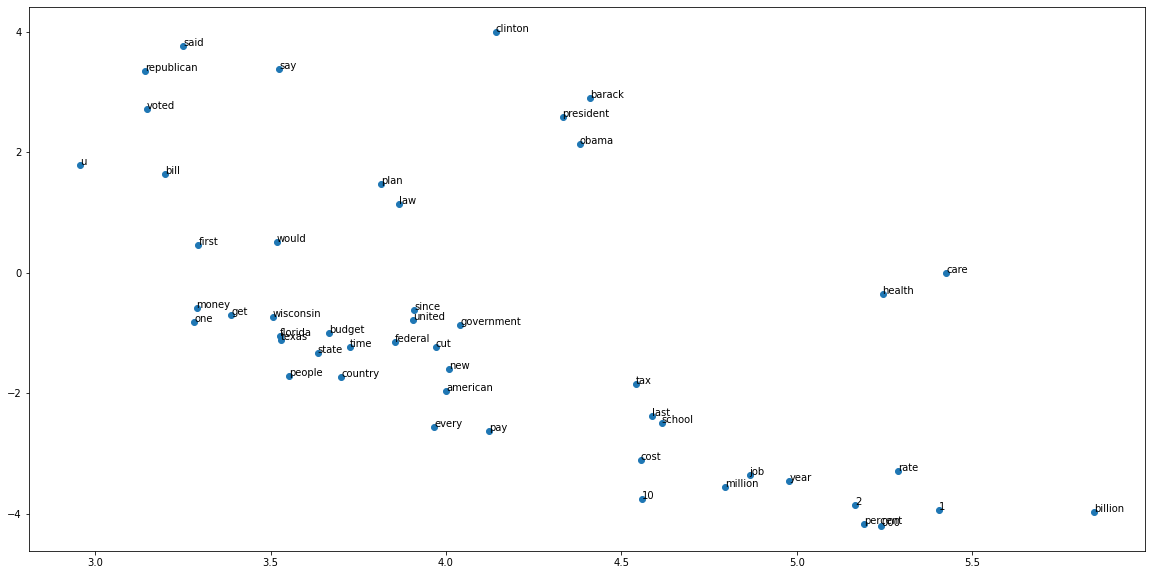

In [16]:
fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(result[:50, 0], result[:50, 1])
words = list(w2v_model.wv.key_to_index)
for i, word in enumerate(words[:50]):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))

In [17]:
# Create a function to show most similar words, or are closest to the given word
def show_most_similar(word, length=10):
    return wv.most_similar(word, topn=length)

#### Examinig Vectors

In [18]:
show_most_similar('trump')

[('propaganda', 0.8974477052688599),
 ('saysabout', 0.884499728679657),
 ('payne', 0.8699000477790833),
 ('carpet', 0.8577377200126648),
 ('insulted', 0.8450868129730225),
 ('sterling', 0.8394962549209595),
 ('said', 0.8376747369766235),
 ('coffman', 0.8322828412055969),
 ('anybodys', 0.8233092427253723),
 ('rooted', 0.8160123229026794)]

In [19]:
show_most_similar('war')

[('iraq', 0.9678844213485718),
 ('succeeded', 0.9641631841659546),
 ('modern', 0.9637889266014099),
 ('longest', 0.9611461758613586),
 ('november', 0.9586124420166016),
 ('sept', 0.9580745100975037),
 ('began', 0.9574408531188965),
 ('actively', 0.9573821425437927),
 ('attack', 0.9559448957443237),
 ('jimmy', 0.9544527530670166)]

In [20]:
show_most_similar('election')

[('confirmed', 0.9745495319366455),
 ('elected', 0.9693313241004944),
 ('confirmation', 0.9674278497695923),
 ('vacancy', 0.9653990268707275),
 ('november', 0.9607394933700562),
 ('running', 0.9595879316329956),
 ('gibbs', 0.9543460607528687),
 ('came', 0.9539734721183777),
 ('husted', 0.9526658654212952),
 ('tweeted', 0.9513237476348877)]

In [21]:
show_most_similar('president')

[('presiding', 0.9597122073173523),
 ('accumulated', 0.9584552049636841),
 ('bush', 0.9551628232002258),
 ('barack', 0.9539368748664856),
 ('administration', 0.9533840417861938),
 ('august', 0.9521856307983398),
 ('w', 0.9512761831283569),
 ('bombed', 0.9512617588043213),
 ('george', 0.9393661022186279),
 ('cabinet', 0.9390082359313965)]

In [22]:
show_most_similar('health')

[('preventive', 0.9469302892684937),
 ('uncompensated', 0.94575035572052),
 ('affordable', 0.9224585294723511),
 ('decent', 0.9131548404693604),
 ('ration', 0.9079880714416504),
 ('act', 0.9067082405090332),
 ('premium', 0.9027366042137146),
 ('pediatric', 0.9011082053184509),
 ('coverage', 0.8912553191184998),
 ('sustaining', 0.8903912305831909)]

In [23]:
from nltk.collocations import *

In [28]:
import nltk

In [25]:
X_train_tokenized = word_tokenize(' '.join(X_train_w2v.apply(lambda x: ' '.join(x))))

In [29]:
# Use BigramAssocMeasures from nltk
bigram_measures = nltk.collocations.BigramAssocMeasures()

finder = BigramCollocationFinder.from_words(X_train_tokenized)
bigrams = finder.score_ngrams(bigram_measures.raw_freq)

In [31]:
# Display the top 50 bigrams
bigrams[:20]

[(('health', 'care'), 0.0035441821349192046),
 (('barack', 'obama'), 0.002574466441829931),
 (('united', 'state'), 0.002565884887023831),
 (('hillary', 'clinton'), 0.0016562400775772554),
 (('president', 'barack'), 0.0013473041045576639),
 (('donald', 'trump'), 0.0011585098988234688),
 (('social', 'security'), 0.0011241836795990697),
 (('president', 'obama'), 0.00111560212479297),
 (('scott', 'walker'), 0.0010898574603746707),
 (('health', 'insurance'), 0.0009611341382831742),
 (('mitt', 'romney'), 0.000926807919058775),
 (('rhode', 'island'), 0.0008238292613855779),
 (('tax', 'cut'), 0.0008066661517733783),
 (('say', 'president'), 0.0007980845969672786),
 (('last', 'year'), 0.0007895030421611787),
 (('year', 'say'), 0.0007551768229367797),
 (('say', 'hillary'), 0.0007294321585184804),
 (('new', 'jersey'), 0.0007208506037123806),
 (('federal', 'government'), 0.0006951059392940813),
 (('illegal', 'immigrant'), 0.0006521981652635824)]

In [32]:
target = y_train_clean
data = X_train_clean.map(word_tokenize).values

In [33]:
total_vocabulary = set(word for headline in data for word in headline)

In [34]:
len(total_vocabulary)
print('There are {} unique tokens in the dataset.'.format(len(total_vocabulary)))

There are 10639 unique tokens in the dataset.


In [35]:
import numpy as np

In [36]:
glove = {}
with open('glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [132]:
# embeddings_dict = {}
# with open("glove.6B.50d.txt", 'r', encoding='utf-8') as f:
#     for line in f:
#         values = line.split()
#         token = values[0]
#         vector = np.asarray(values[1:], "float32")
#         embeddings_dict[token] = vector

In [37]:
embeddings_dict2 = {}
with open("glove.6B.200d.txt", 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        token = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict2[token] = vector

In [38]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [44]:
def find_closest_embeddings(embedding, cutoff=25):
    return sorted(embeddings_dict2.keys(), key=lambda token: spatial.distance.euclidean(embeddings_dict2[token], embedding))

In [40]:
from scipy import spatial

In [45]:
print(find_closest_embeddings(
    embeddings_dict2["twig"] - embeddings_dict2["branch"] + embeddings_dict2["hand"]
)[:5])

['twig', 'hand', 'cupping', 'paddles', 'caressing']


In [46]:
from sklearn.manifold import TSNE

In [48]:
tsne = TSNE(n_components=2, random_state=0)

tokens = list(embeddings_dict2.keys())
vectors = [embeddings_dict2[token] for token in tokens]

Y = tsne.fit_transform(vectors[:200])

In [49]:
import matplotlib.pyplot as plt

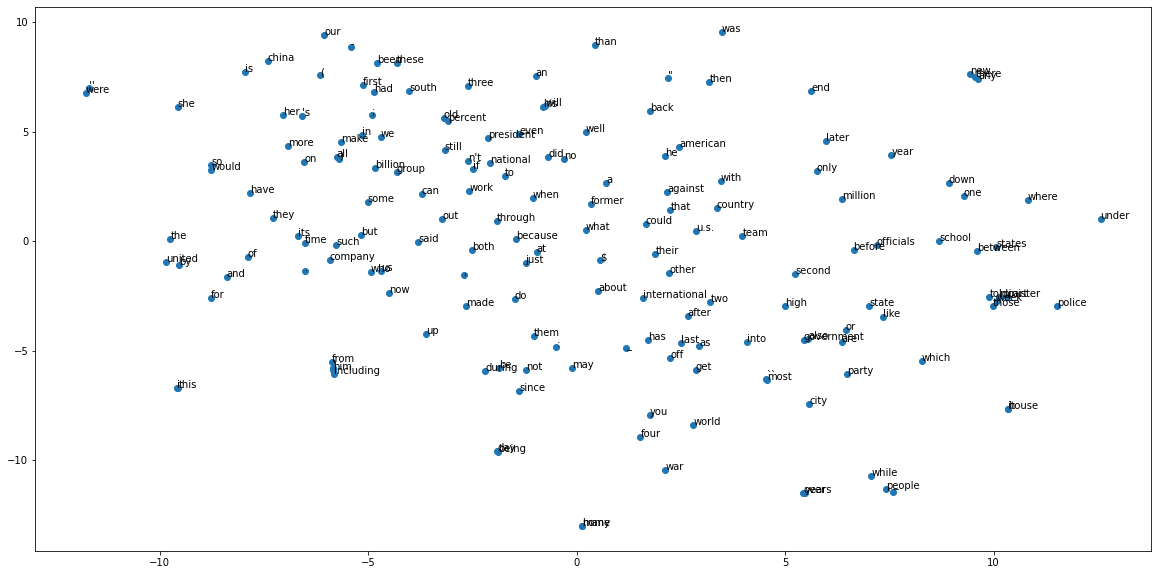

In [52]:
fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(Y[30:, 0], Y[30:, 1])
for label, x, y in zip(tokens, Y[30:, 0], Y[30:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

rf =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Random Forest', RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=22, ccp_alpha=0.1, verbose=True))])
svc = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                ('Support Vector Machine', SVC())])
lr = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Logistic Regression', LogisticRegression(C=0.1, solver='liblinear'))])
sgd = Pipeline([('Vectorizer', W2vVectorizer(glove)),
                ('Stochastic Gradient Descent', SGDClassifier(fit_intercept=False, early_stopping=True, alpha=0.01, loss='log'))])

In [54]:
models = [('Random Forest', rf),
          ('Support Vector Machine', svc),
          ('Logistic Regression', lr),
          ('Stochastic Gradient Descent', sgd)]

In [55]:
scores = [(name, cross_val_score(model, data, target, cv=2).mean()) for name, model, in models]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [56]:
scores

[('Random Forest', 0.56171875),
 ('Support Vector Machine', 0.5958984375),
 ('Logistic Regression', 0.5919921875),
 ('Stochastic Gradient Descent', 0.5927734375)]

In [57]:
rf2 =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(embeddings_dict2)),
              ('Random Forest', RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=22, ccp_alpha=0.1, verbose=True))])
svc2 = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(embeddings_dict2)),
                ('Support Vector Machine', SVC())])
lr2 = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(embeddings_dict2)),
              ('Logistic Regression', LogisticRegression(C=0.1, solver='liblinear'))])
sgd2 = Pipeline([('Vectorizer', W2vVectorizer(embeddings_dict2)),
                ('Stochastic Gradient Descent', SGDClassifier(fit_intercept=False, early_stopping=True, alpha=0.01, loss='log'))])

In [58]:
models2 = [('Random Forest', rf2),
          ('Support Vector Machine', svc2),
          ('Logistic Regression', lr2),
          ('Stochastic Gradient Descent', sgd2)]

In [59]:
scores2 = [(name, cross_val_score(model, data, target, cv=2).mean()) for name, model, in models2]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   15.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   18.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [60]:
scores2

[('Random Forest', 0.56171875),
 ('Support Vector Machine', 0.6068359375000001),
 ('Logistic Regression', 0.60205078125),
 ('Stochastic Gradient Descent', 0.59873046875)]